In [1]:
import torch
from torch import optim
from torch.utils.data import Subset, Dataset, DataLoader, IterableDataset
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image
from tqdm import tqdm
from datetime import datetime
import math
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
# req torch, torchvision, einops, tqdm, ema_pytorch, accelerate
from IPython.display import display
from einops import rearrange, reduce, repeat
import glob
from ema_pytorch import EMA
from scipy.optimize import linear_sum_assignment

import os
CWD = os.getcwd()

# Device stuff
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Remember to use {device} device from here on")
print(os.chdir("../"))
# %cd /home/physics/phuqza/E9/DDPM-HL-LHC/
from DDPMLHC.config import *
from DDPMLHC.calculate_quantities import *
from DDPMLHC.data_loading import *
from DDPMLHC.generate_plots.overlaid_1d import create_overlay_plots
from DDPMLHC.generate_plots.bmap import save_to_bmap


# Some functions from denoising_diffusion_pytorch that are required but couldn't import
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/physics/phuftc/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True
GPU Device: NVIDIA RTX A4000
Number of GPUs: 1
Remember to use cuda device from here on
None


In [2]:
def show_tensor_images(tensor_images, scale_factor=8):
    to_pil = T.ToPILImage()
    pil_images = [to_pil(image) for image in tensor_images]

    for img in pil_images:
        # Upscale the image
        upscaled_img = img.resize(
            (img.width * scale_factor, img.height * scale_factor), 
            Image.NEAREST  # or Image.BOX for smoother results
        )
        display(upscaled_img)


In [3]:
# Function to load last checkpoint and train the model
def load_and_train(
    diffusion,
    dataloader,
    num_epochs,
    device,
    save_dir,
    lr=1e-4
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Get last epoch number
    checkpoint_files = glob.glob(os.path.join(save_dir, 'checkpoint_epoch_*.pth'))
    last_epoch = 0
    if checkpoint_files:
        epoch_numbers = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[1].split('_loss')[0])
                epoch_numbers.append(epoch_num)
            except:
                continue
        last_epoch = max(epoch_numbers) if epoch_numbers else 0

    # Load checkpoint if exists
    if last_epoch > 0:
        checkpoint_pattern = os.path.join(save_dir, f'checkpoint_epoch_{last_epoch}_*.pth')
        checkpoint_file = glob.glob(checkpoint_pattern)[0]
        print(f"Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=device)
        diffusion.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Starting fresh training")

    optimizer = optim.Adam(diffusion.parameters(), lr=lr)

    for epoch in range(last_epoch, last_epoch + num_epochs):
        print(f"\nEpoch {epoch + 1}/{last_epoch + num_epochs}")
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

        running_loss = 0.0
        loss_array = []
        for i, images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            loss = diffusion(images)
            loss.backward()
            optimizer.step()
            loss_array.append(loss)
            running_loss += loss.item()
            # print(running_loss)
            avg_loss = running_loss / (i + 1)
            # avg_loss = np.mean(loss_array)
            progress_bar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        # Save checkpoint at the end of each epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}_loss_{avg_loss:.4f}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': diffusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')


In [4]:

MAX_DATA_ROWS = None

# === Read in data
print("0 :: Loading original data")
tt = np.genfromtxt(
    TT_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
pu = np.genfromtxt(
    PILEUP_PATH, delimiter=",", encoding="utf-8", skip_header=1, max_rows=MAX_DATA_ROWS
)
tt = EventSelector(tt)
pu = EventSelector(pu)
print("FINISHED loading data\n")
bins=16
# Ground truth ttbar jets
NG_jet = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0)
# Second one to randomly generate and return pile-up events ONLY
## Will use np.random.randint to generate NoisyGenerator.mu and then call next
NG_pu = NoisyGenerator(TTselector=tt, PUselector=pu, bins=bins, mu=0, pu_only=True)

class OutData():
    def __init__(self, vector, axis=(0,0)):
        pass



0 :: Loading original data
FINISHED loading data



In [5]:
# class NGenForDataloader(Dataset):
#     def __init__(self, noisy_generator):
#         self.ng = noisy_generator
#         next(self.ng)
#     def __iter__(self):
#         return self
    
#     def __len__(self):
#         return len(self.ng)-1
    
#     def __getitem__(self, idx):
#         self.ng.select_jet(idx)
#         x = torch.from_numpy( self.ng.get_grid() )
#         # x = x.unsqueeze(0)
#         x = x.unsqueeze(0)
#         # y = x
#         return x

class NGenForDataloader(IterableDataset):
    def __init__(self, noisy_generator, batch_size=1):
        super().__init__()
        self.ng = noisy_generator # NoisyGenerator instance that feeds in jet data
        self.batch_size = batch_size # batch_size should select batch_size number of jets
        self.ng.reset()
        # next(self.ng)
    
    # USING THIS TO MAKE IterableDataset for model
    # So dataset is "streamed in" continously instead of specifically "selecting" a jet
    # Hence in each timestep, 
    def generate_jet(self):
        # while self.ng._next_jetID  self.ng._max_TT_no: 
        #     if :
        #         raise RuntimeError("Requested jet not in loaded set. Did nothing.")
        #     # Define empty image tensor
        # while True:
        image_data = []
        # images = torch.empty(size=(self.batch_size,1,self.ng.grid_side_bins,self.ng.grid_side_bins))
        # Ensure that if the remainder of data cannot fit in batch_size, just fit thhe rest of the data into one batch
        jet_range = range(self.ng._next_jetID, self.ng._next_jetID + batch_size) if self.ng._max_TT_no - self.ng._next_jetID > batch_size else range(self.ng._next_jetID, self.ng._max_TT_no)
        for jet_no in jet_range:
            self.ng.select_jet(jet_no) # Select jet, now self.ng.current_event is set
            image = torch.from_numpy(self.ng.get_grid())# Converted to bins x bins image and now tensor
            image_data.append(image)
        # Now image_data is (self.batch_size, bins, bins)
        image_data = torch.stack(image_data)
        image_data = image_data.unsqueeze(1) # Add channels, set to 1
        # image_data = image_data.to(device)
        yield image_data
            
    def __iter__(self):
        # if self.ng._next_jetID >= self.ng._max_TT_no:
        #     self.ng.reset() # Reset for next cycle through the dataset
        #     raise StopIteration  # Stops for loop after
        # else: 
        return self.generate_jet()
    def __next__(self):
        # if self.ng._next_jetID >= self.ng._max_TT_no:
        #     self.ng.reset() # Reset for next cycle through the dataset
        #     raise StopIteration  # Stops for loop after
        # else: 
            return self.generate_jet()
    def __len__(self):
        return len(self.ng.current_event)
    
    def __getitem__(self, idx):
        self.ng.select_jet(idx)
        x = torch.from_numpy( self.ng.get_grid() )
        # x = x.unsqueeze(0)
        x = x.unsqueeze(0)
        # y = x
        return x

In [6]:
model = Unet(
    dim=64,                  # Base dimensionality of feature maps
    dim_mults=(1, 2, 4, 8),  # Multipliers for feature dimensions at each level
    channels=1,              # E.g. 3 for RGB
).to(device)

class PUDiffusion(GaussianDiffusion):
    def __init__(self, model, image_size, puNG: NoisyGenerator, **kwargs):
        super(PUDiffusion, self).__init__(model=model, image_size=image_size, **kwargs)
        self.puNG = puNG
    def cond_noise(self, x_start, t, noise):
        return self.pu_to_tensor(x_start, t) if noise is None else noise
    def pu_to_tensor(self, x_start, t):
        # Select random number of pile-ups (mu) to generate, max 200 for now since HL-LHC expected to do up to this
        # We are doing it per batch
        # if isinstance(t, int):
        #     mu = np.random.randint(low=1, high=200, size=None)
        # else:
        #     mu = np.random.randint(low=1, high=200, size=None)
        mu = 1
        # print(mu)
        self.puNG.mu = mu
        next(self.puNG)
        selected_pu = self.puNG.get_grid()
        # If empty pile-up, return array of 0s instead since model should account for this
        if selected_pu.size == 0:
            return  torch.zeros_like(x_start)
        # print(selected_pu.shape)
        pu_tensor = torch.from_numpy(selected_pu)

        pu_tensor = torch.unsqueeze(pu_tensor,0)
        # This tensor has dimensions BxCxHxW to match x_start
        pu_tensor = torch.unsqueeze(pu_tensor,0)
        pu_tensor = pu_tensor.expand(x_start.shape[0], x_start.shape[1], -1, -1)  #
        pu_tensor = pu_tensor.to(self.device)
        # print(pu_tensor.shape)
        # show_tensor_images(pu_tensor)
        return pu_tensor
    # TODO: ddim_sample???
    @torch.inference_mode()
    def p_sample(self, x, t: int, x_self_cond = None):
        b, *_, device = *x.shape, self.device
        batched_times = torch.full((b,), t, device = device, dtype = torch.long)
        # print("batched times", t)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = True)
        ######## MODIFY
        noise = self.pu_to_tensor(x, t) if t > 0 else 0 # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start
    def q_sample(self, x_start, t, noise = None):
        noise = self.cond_noise(x_start=x_start, t = t, noise=noise)

        if self.immiscible:
            assign = self.noise_assignment(x_start, noise)
            noise = noise[assign]
        # print("q_sample t", t)
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )


    def p_losses(self, x_start, t, noise = None, offset_noise_strength = None):
        b, c, h, w = x_start.shape
        # Select one pile-up at a time for each timestep $t$
        # single_pileup = self.pu.select_event(np.random.randint(low=0, high=self.pu.max_ID, size=1))
        # print("p_losses t", t)

        noise = self.cond_noise(x_start=x_start, t = t, noise=noise)

        # if noise is None: 
        # noise = default(noise, lambda: torch.randn_like(x_start))
        # offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

        # if offset_noise_strength > 0:
        #     offset_noise = torch.randn(x_start.shape[:2], device = self.device)
        #     noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

# diffusion = GaussianDiffusion(
#     model = model,
#     image_size = 16,  # Size of your images (ensure your images are square)
#     timesteps = 1000,  # Number of diffusion steps
#     objective = "pred_x0",
# ).to(device)

diffusion = PUDiffusion(
    model = model,
    puNG = NG_pu,
    image_size = bins,  # Size of your images (ensure your images are square)
    timesteps = 200,  # Number of diffusion steps
    objective = "pred_x0",
).to(device)

sampling loop time step:   0%|          | 1/200 [00:00<00:36,  5.39it/s]/storage/physics/phuftc/DDPM-HL-LHC/DDPMLHC/calculate_quantities.py:36: RuntimeWarning: invalid value encountered in double_scalars
  return np.arctanh(p_z / p_mag)
/storage/physics/phuftc/DDPM-HL-LHC/DDPMLHC/data_loading.py:237: RuntimeWarning: invalid value encountered in sqrt
  self.event_mass = np.sqrt(event_p2)
sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 90.06it/s]


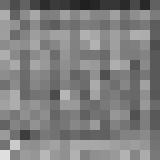

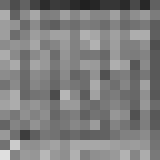

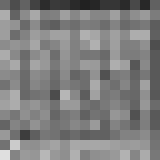

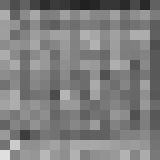

In [7]:
# Generate samples
batch_size = 4
sampled_images = diffusion.sample(batch_size=batch_size)
show_tensor_images(sampled_images, scale_factor=10)

In [8]:
# this one is to be passed into DataLoader for training
ng_for_dataloader = NGenForDataloader(NG_jet,batch_size=1000)
# We handle batching ourselves, by serving "batch_size" number of jets to train on each time
dataloader = DataLoader(ng_for_dataloader, batch_size=None, num_workers=1)
# print(dataloader)
#print(ng_for_dataloader)
pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
show_tensor_images(pats, scale_factor=10)
# print(tt.select_event(0).shape)
save_dir = f"{CWD}/data/ML/second"
num_epochs = 5


# print(f"{len(ng_for_dataloader)} jets, {ng_for_dataloader.batch_size} batches, {num_epochs} epochs")
load_and_train(diffusion, dataloader, num_epochs=num_epochs, device=device, save_dir=save_dir, lr=1e-10)
print("Finished training")

Loading checkpoint: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_10_loss_1066.9532.pth

Epoch 11/15


1it [00:00,  5.04it/s, Loss=467.0770]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_11_loss_467.0770.pth

Epoch 12/15


0it [00:00, ?it/s]/home/physics/phuftc/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:725: UserWarning: Length of IterableDataset <__main__.NGenForDataloader object at 0x7f512d590a30> was reported to be 0(when accessing len(dataloader)), but 1 samples have been fetched. For multiprocessing data-loading, this could be caused by not properly configuring the IterableDataset replica at each worker. Please see https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.
  warnings.warn(warn_msg)
1it [00:00, 15.65it/s, Loss=3482.0273]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_12_loss_3482.0273.pth

Epoch 13/15


1it [00:00, 16.47it/s, Loss=28835.9355]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_13_loss_28835.9355.pth

Epoch 14/15


1it [00:00, 16.16it/s, Loss=61378.0352]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_14_loss_61378.0352.pth

Epoch 15/15


1it [00:00, 16.47it/s, Loss=2633.3755]


Checkpoint saved: /storage/physics/phuftc/DDPM-HL-LHC/data/ML/second/checkpoint_epoch_15_loss_2633.3755.pth
Finished training


In [9]:
# Set model to evaluation mode
model.eval()
diffusion.eval()

PUDiffusion(
  (model): Unet(
    (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=64, out_features=256, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (block2): Block(
            (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inpla

sampling loop time step: 100%|██████████| 200/200 [00:02<00:00, 96.87it/s]


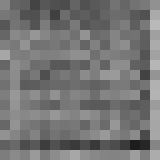

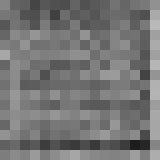

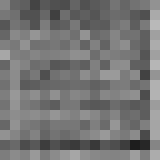

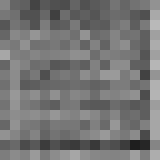

In [10]:
# Generate samples
NG_jet.reset()
NG_pu.reset()
sampled_images = diffusion.sample(batch_size=batch_size)
show_tensor_images(sampled_images, scale_factor=10)


0


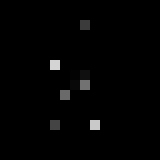

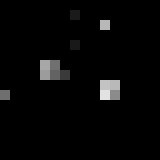

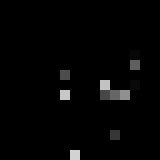

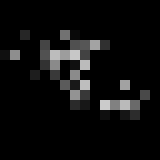

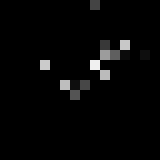

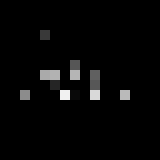

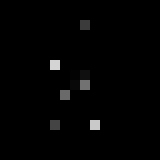

In [11]:
print(len(ng_for_dataloader))
pats = [ng_for_dataloader[0],ng_for_dataloader[1],ng_for_dataloader[2],ng_for_dataloader[3],ng_for_dataloader[4],ng_for_dataloader[5], ng_for_dataloader[-1]]
show_tensor_images(pats, scale_factor=10)

In [11]:
# class PileupDiffusion(GaussianDiffusion):
#     def __init__(
#         self,
#         model,
#         *,
#         image_size,
#         timesteps = 1000,
#         sampling_timesteps = None,
#         objective = 'pred_v',
#         beta_schedule = 'sigmoid',
#         schedule_fn_kwargs = dict(),
#         ddim_sampling_eta = 0.,
#         auto_normalize = True,
#         offset_noise_strength = 0.,  # https://www.crosslabs.org/blog/diffusion-with-offset-noise
#         min_snr_loss_weight = False, # https://arxiv.org/abs/2303.09556
#         min_snr_gamma = 5,
#         immiscible = False
#     ):
#         super().__init__()